In [38]:
import numpy as np
from scipy import stats, optimize

def backorder_loss(q, x, d_mean, d_std, p_cost):
    dist = stats.norm(d_mean[0], d_std[0])
    penalty = dist.expect(lambda u: p_cost*(u - x - q), lb=(x+q))
    return penalty

def der_backorder_loss(q, x, d_mean, d_std, p_cost):
    dist = stats.norm(d_mean[0], d_std[0])
    der_penalty = p_cost*(1 - dist.cdf(x + q))
    return der_penalty

def holding_loss(q, x, d_mean, d_std, h_cost, tol=1e-6):
    holding = 0
    for mean, var in zip(np.cumsum(d_mean), np.cumsum(np.square(d_std))):
        dist = stats.norm(mean, np.sqrt(var))
        held = dist.expect(lambda u: h_cost*(x + q - u), lb=x, ub=(x+q))
        if held < tol:
            break
        holding += held
    return holding

def der_holding_loss(q, x, d_mean, d_std, h_cost, tol=1e-6):
    der_holding = 0
    for mean, var in zip(np.cumsum(d_mean), np.cumsum(np.square(d_std))):
        dist = stats.norm(mean, np.sqrt(var))
        held = dist.cdf(x + q) - dist.cdf(x)
        der_holding += h_cost*held
    return der_holding

In [134]:
demand_mean = np.repeat(175, 50)
demand_std = np.repeat(15, 50)
x = 10
p_cost = 5
h_cost = 1

def r(q):
    return holding_loss(q, x, demand_mean, demand_std, h_cost) \
        - backorder_loss(q, x, demand_mean, demand_std, p_cost)
    
def dr(q):
    return der_holding_loss(q, x, demand_mean, demand_std, h_cost) \
        + der_backorder_loss(q, x, demand_mean, demand_std, p_cost)
print("Bisection: ")
q_bisect, res = optimize.bisect(r, 100, 300, full_output=True)
print(q_bisect)
print("Newton: ")
q_newton = optimize.newton(r, 170, fprime=dr)
print(q_newton)
grid_q = np.arange(140, 200)
grid_r = np.zeros_like(grid_q)
grid_dr = np.zeros_like(grid_q)
for i, gq in enumerate(grid_q):
    grid_r[i] = r(gq)
    grid_dr[i] = dr(gq)

Bisection: 
174.5404092692482
Newton: 
174.540409269


Populating the interactive namespace from numpy and matplotlib


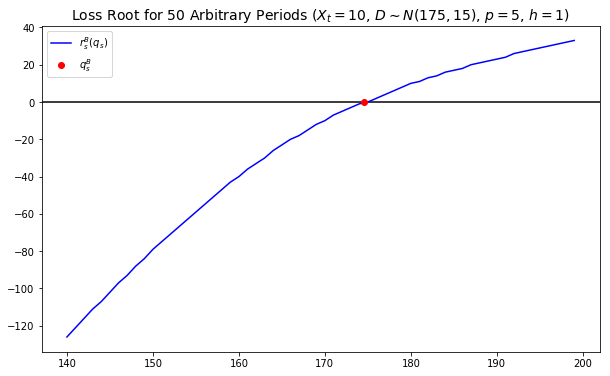

In [57]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
import matplotlib.pyplot as plt

plt.clf()
plt.axhline(y=0, c="k")
plt.title("Loss Root for 50 Arbitrary Periods ($X_t = 10$, $D \sim N(175, 15)$, $p = 5$, $h = 1$)", fontsize=14)
plt.plot(grid_q, grid_r, "b", markersize=2, label="$r_s^B(q_s)$")
plt.plot([q], [r(q)], "ro", label="$q_s^B$")
plt.legend()
plt.savefig("root.pdf")
plt.show()

In [101]:
%%cython
import numpy as np
cimport numpy as np
from libc.math cimport pow

cdef double pos(double x):
    if x > 0:
        return x
    else:
        return 0.0

cdef double holding(double q, double x, double[:] d, double a, double h):
    cdef total_holding = 0
    cdef n_held = 0
    cdef cum_demand = 0
    for i in range(len(d)):
        cum_demand += d[i]
        n_held = pos(q - pos(cum_demand - x))
        if n_held <= 0:
            break
        else:
            total_holding += pow(a, i)*h*n_held
    return total_holding
        
cdef double penalty(double q, double x, double d, double p):
    return p*pos(d - x - q)
    
def loss_max(q, x, d, a, p, h):
    return max(holding(q, x, d, a, h), penalty(q, x, d[0], p))

def loss_root(q, x, d, a, p, h):
    return holding(q, x, d, a, h) - penalty(q, x, d[0], p)

In file included from /usr/local/lib/python3.5/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1809:0,
                 from /usr/local/lib/python3.5/dist-packages/numpy/core/include/numpy/ndarrayobject.h:18,
                 from /usr/local/lib/python3.5/dist-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /home/andrew/.cache/ipython/cython/_cython_magic_290dec840ed6eb1540f0ae9bf835754f.c:541:
/usr/local/lib/python3.5/dist-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: #warning "Using deprecated NumPy API, disable it by " "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it by " \
  ^


In [176]:
n_reps = 2500
n_chains = 5
qcs = []
fq = []
for c in range(n_chains):
    q = np.random.uniform(100, 300)
    qs = [q]
    for rep in range(1, n_reps):
        demand = np.random.multivariate_normal(np.repeat(175, 50), np.diag(np.repeat(15**2, 50)))
        q -= (1/rep)*loss_root(q, 10, demand, 1, 5, 1)
        qs.append(q)
    fq.append(q)
    qcs.append(qs)
traces = np.array(qcs)
q_robbins = np.mean(traces[:, 500::5])
print(q_robbins)

174.644988966


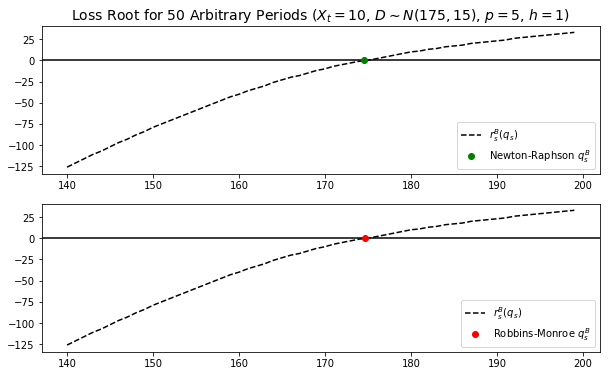

In [178]:
import matplotlib.pyplot as plt

plt.clf()
plt.subplot(2, 1, 1)
plt.axhline(y=0, c="k")
plt.title("Loss Root for 50 Arbitrary Periods ($X_t = 10$, $D \sim N(175, 15)$, $p = 5$, $h = 1$)", fontsize=14)
plt.plot(grid_q, grid_r, "k--", markersize=.2, label="$r_s^B(q_s)$")
plt.plot([q_newton], [r(q_newton)], "go", label="Newton-Raphson $q_s^B$")
plt.legend()
plt.subplot(2, 1, 2)
plt.axhline(y=0, c="k")
plt.plot(grid_q, grid_r, "k--", markersize=.2, label="$r_s^B(q_s)$")
plt.plot([q_robbins], [r(q_robbins)], "ro", label="Robbins-Monroe $q_s^B$")
plt.legend()
plt.savefig("compared.pdf")
plt.show()

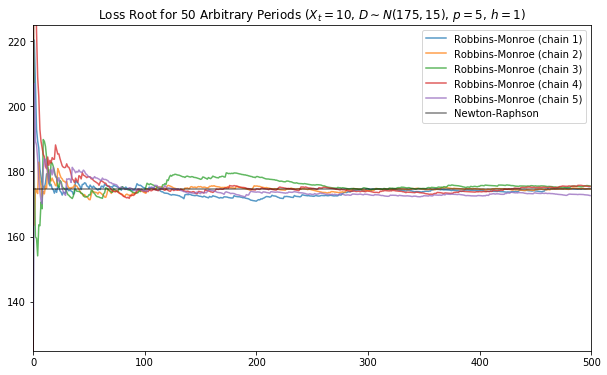

In [168]:
plt.title("Loss Root for 50 Arbitrary Periods ($X_t = 10$, $D \sim N(175, 15)$, $p = 5$, $h = 1$)")
for i, qs in enumerate(qcs):
    plt.plot(qs, alpha=.75, label="Robbins-Monroe (chain %s)" % (i + 1))
plt.axhline(y=q_newton, alpha=.5, c="k", label="Newton-Raphson")
plt.ylim(125, 225)
plt.xlim(0, 500)
plt.legend()
plt.savefig("rbtraces.pdf")
plt.show()